In [58]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
from matplotlib.patches import Patch

# statsmodels and sklearn are currently not used. Both packages can be omitted for now, but sklearn will
# very likely be used in the future

%matplotlib inline
#sns.set_theme(font="Arial")
# Folder containing the data file
#data_dir = r'F:\Andrew Markel\Ultrasound Data' # For UITC 2023 talk
data_dir = r'D:\Andrew\Prolapse Model'  # For UITC 2023 talk

# Name of the file containing the QUS results
#data_fid = r'2023-03-07_GD14-18.csv'
data_fid = r'2025-07-07-all-frames.csv'
key_fid = r'anatomy_qus.csv'

# Define an array of the QUS parameter names. This will be useful later
qus_params = ['ESD','EAC','MBF','SS','I0','Naka Omega','Naka m','HK k','HK alpha']
qus_params_key = ['ESD ($\mu$m)','EAC (dB/m$^{3}$)','MBF (dB/sr/m)','SS (dB/sr/m/MHz)','I0 (dB/sr/m)','Naka $\Omega$ (kV$^{2}$)','Naka m (a.u.)','HK $\kappa$ (a.u.)','HK $\\alpha$ (a.u.)']

# Move to the data folder and read the .csv into a DataFrame
os.chdir(data_dir)
all_data = pd.read_csv(data_fid)
key_data = pd.read_csv(key_fid)

# Rename the columns using abbreviations for the parameter names
new_names = {'HKStructureParam':'HK k','HKScattererClusteringParam':'HK alpha','NakShapeParam':'Naka m','NakScaleFactor':'Naka Omega', 
             'SpectralSlope':'SS','Intercept':'I0','MidbandFit':'MBF','EffectiveScattererSize':'ESD','AcousticConcentration':'EAC'}

all_data.rename(new_names,axis=1,inplace=True)

# Convert ESD from m to um
all_data['ESD'] *= 1e6
all_data['Naka Omega'] /= 1e6

# Log compress the Nakagami Omega and HK alpha parameters
#all_data['Naka Omega'] = np.log10(all_data['Naka Omega'])
#all_data['HK alpha'] = np.log10(all_data['HK alpha'])

# As a precaution, remove any rows that contain a NaN in any column
all_data.dropna(axis=0,inplace=True)

all_data_copy = all_data.copy()

# Based on the ID string, split into new columns with ID, Day, and Frame #
#all_data[['ID','Day','Frame']] = all_data['ID'].str.split('_',2,expand=True)

# Convert Day column into integer data type (instead of string)
#all_data['Day'] = all_data['Day'].astype(int)

# # Keep only the first 5 characters from the ID - the last specifies placenta (not animal) and is not needed at this time
# # This will make it easier to separate the Normal and treat groups
# all_data['ID'] = all_data['ID'].str[:5]

# Remove any rows where the ESD is zero 
# This means QUS estimation failed
remove_idx = (all_data['ESD'] <= 0)
all_data.drop(all_data.loc[remove_idx].index,inplace=True)

#sum_data = all_data.groupby(['ID'],as_index=False).count()

# Group by animal
#all_data.loc[:,'Animal'] = all_data['ID'].str[:5]

# #Specify placentas which do not meet the criteria for inclusion in this study
#drop_placentas = {'N6_C4_FM','N6_F2','N8_C1_M','P1_C2_M','P2_C1_F','P2_C1_M','P2_C2_F','P2_C2_M','P2_C3_F','P2_C3_M','P2_C4_F','P2_C4_M','P2_C5_F','P2_C5_M','P2_C6_F','P2_C6_M'}

#for drop_p in drop_placentas:
#    all_data.drop(all_data.loc[all_data['ID'] == drop_p].index,inplace=True)

# Based on the ID string, split into new columns with ID, Day, and Frame #
#all_data[['ID','Cotyledon','Side']] = all_data['ID'].str.split('_',2,expand=True)

#Group by animal
#all_data.loc[:,'Type'] = all_data['ID'].str[0:1]
#all_data['Distance'] = all_data['Distance']*100
#all_data['Distance'] = all_data['Distance'].astype(int)
#all_data['Distance'] = all_data['Distance'].astype(str)
#all_data

rp = [(230,171,36),(0,158,115),(173,111,214)]
rp = list(tuple(ti/256 for ti in t) for t in rp)

#in_data = all_data[all_data['Side'] == 'F']
ids = key_data.ID

for i in ids:
    i_str = 'M' + str(i) 
    g = key_data[key_data['ID'] == i]['Grade'].values
    print(g)

    if g > 0:
        all_data.loc[all_data['ID'] == i_str,'Type'] = 'Prolapsed'
    else:
        all_data.loc[all_data['ID'] == i_str,'Type'] = 'Normal'

in_data = all_data.groupby(['ID','Organ','Type'],as_index = False).mean()

in_data

#in_data

[0]
[0]
[0]
[0]
[0]
[2]
[0]
[2]
[0]
[0]
[0]
[0]
[3]
[2]
[2]


,ID,Organ,Type,HK k,HK alpha,Naka m,Naka Omega,SS,I0,MBF,ESD,EAC,ROIZDist,XCoord,YCoord,ZCoord
0,M1033,external,Prolapsed,0.153920,0.848910,0.679372,0.319488,0.197146,11.110881,16.729534,11.467694,123.754431,0.000749,0.005301,1.0,0.006207
1,M1033,vagina,Prolapsed,0.145847,0.717510,0.620059,0.661297,0.115803,19.811676,23.112072,12.357238,129.480751,0.000944,0.004749,1.0,0.006141
2,M1064,external,Prolapsed,0.121842,1.200622,0.583693,0.989818,0.011236,17.705064,18.025288,13.584256,123.824073,0.001324,0.005972,1.0,0.006781
3,M1064,internal,Prolapsed,0.060004,0.706950,0.495351,1.485324,-0.127308,22.785446,19.157167,14.823616,124.628129,0.000908,0.006116,1.0,0.006821
4,M1064,uterus,Prolapsed,0.000028,2.179985,0.728059,0.254273,0.255408,10.566277,17.845395,10.754933,125.623036,0.000608,0.006267,1.0,0.006749
5,M1064,vagina,Prolapsed,0.081086,0.589716,0.524490,0.521537,-0.214351,21.396715,15.287708,15.626966,120.956217,0.001487,0.005170,1.0,0.006423
6,M805,external,Normal,0.070182,0.331537,0.455205,0.323906,-0.199949,21.811444,16.112910,15.525811,121.581502,0.000750,0.007509,1.0,0.005491
7,M805,internal,Normal,0.033179,0.690874,0.517465,0.225489,-0.043462,18.954790,17.716127,14.130505,123.248856,0.000916,0.007739,1.0,0.005462
8,M805,uterus,Normal,0.034107,0.408011,0.418366,0.565083,-0.005261,22.015238,21.865307,13.713659,127.607637,0.001016,0.007555,1.0,0.005268
9,M805,vagina,Normal,0.126838,0.499225,0.576475,0.246111,-0.107302,17.378431,14.320327,14.706588,119.786113,0.000749,0.007785,1.0,0.005522


In [ ]:
#corr_data = in_data.groupby(['Type','Animal','Distance'],as_index = False).mean()
#corr_data

In [59]:
#Calculate signficance between Preeclamptic and Normal groups at each distance
all_dist = ["vagina","external","internal","uterus"]
all_types = ["Normal","Prolapsed"]
print(all_dist)

['vagina', 'external', 'internal', 'uterus']


In [60]:
p_mat = np.zeros((len(qus_params),len(all_dist)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, dist in enumerate(all_dist):
    #dist = str(round(dist,1))
    #print(in_data['ESD'])
    sub_df = in_data[in_data['Organ'] == dist]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        var_c = sub_df[sub_df['Type'] == 'Normal'][param]
        var_r = sub_df[sub_df['Type'] == 'Prolapsed'][param]

        #print(var_c)
        #print(var_r)

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        #print(this_p)
        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df_dist = pd.DataFrame(p_mat,index=qus_params,columns=all_dist)
diff_df_dist = pd.DataFrame(diff_mat,index=qus_params,columns=all_dist)

p_df_dist

C:\Users\amarkel\AppData\Local\Temp\ipykernel_38204\1859184172.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat[q_idx,d_idx] = this_p


,vagina,external,internal,uterus
ESD,0.306073,0.005426,0.791098,0.191036
EAC,0.607821,0.672108,0.674554,0.618137
MBF,0.654314,0.805195,0.647547,0.816435
SS,0.321873,0.002639,0.778996,0.225593
I0,0.578568,0.161551,0.727993,0.228641
Naka Omega,0.124253,0.151354,0.000582,0.795252
Naka m,0.233230,0.063284,0.764888,0.005797
HK k,0.397667,0.040934,0.852608,0.123431
HK alpha,0.046248,0.008407,0.299057,0.000035


In [63]:
#Procedurally generate comparison pairs
comp_pairs = [None]*len(all_dist)
print(comp_pairs)

for d_idx, dist in enumerate(all_dist):
    comp_pairs[d_idx] = [(dist,'Normal'),(dist,'Prolapsed')]

print(comp_pairs)

[None, None, None, None]
[[('vagina', 'Normal'), ('vagina', 'Prolapsed')], [('external', 'Normal'), ('external', 'Prolapsed')], [('internal', 'Normal'), ('internal', 'Prolapsed')], [('uterus', 'Normal'), ('uterus', 'Prolapsed')]]


[0.3060727836354214, 0.005425515398565424, 0.7910977873422946, 0.19103599677681368]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

external_Normal vs. external_Prolapsed: Custom statistical test, P_val:5.426e-03
vagina_Normal vs. vagina_Prolapsed: Custom statistical test, P_val:3.061e-01
internal_Normal vs. internal_Prolapsed: Custom statistical test, P_val:7.911e-01
uterus_Normal vs. uterus_Prolapsed: Custom statistical test, P_val:1.910e-01
[0.6078210223129464, 0.672107652166289, 0.6745541324654596, 0.6181374475220474]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

external_Normal vs. external_Prolapsed: Custom statistical test, P_val:6.721e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


vagina_Normal vs. vagina_Prolapsed: Custom statistical test, P_val:6.078e-01
internal_Normal vs. internal_Prolapsed: Custom statistical test, P_val:6.746e-01
uterus_Normal vs. uterus_Prolapsed: Custom statistical test, P_val:6.181e-01
[0.6543139440348573, 0.8051947608183873, 0.6475466178983788, 0.8164346386442691]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

external_Normal vs. external_Prolapsed: Custom statistical test, P_val:8.052e-01
vagina_Normal vs. vagina_Prolapsed: Custom statistical test, P_val:6.543e-01
internal_Normal vs. internal_Prolapsed: Custom statistical test, P_val:6.475e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


uterus_Normal vs. uterus_Prolapsed: Custom statistical test, P_val:8.164e-01
[0.3218730434410669, 0.0026394481342579016, 0.7789962005942856, 0.22559342318381287]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

external_Normal vs. external_Prolapsed: Custom statistical test, P_val:2.639e-03
vagina_Normal vs. vagina_Prolapsed: Custom statistical test, P_val:3.219e-01
internal_Normal vs. internal_Prolapsed: Custom statistical test, P_val:7.790e-01
uterus_Normal vs. uterus_Prolapsed: Custom statistical test, P_val:2.256e-01
[0.578568242329638, 0.16155103945949112, 0.7279931646999904, 0.22864115630166468]


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

external_Normal vs. external_Prolapsed: Custom statistical test, P_val:1.616e-01
vagina_Normal vs. vagina_Prolapsed: Custom statistical test, P_val:5.786e-01
internal_Normal vs. internal_Prolapsed: Custom statistical test, P_val:7.280e-01
uterus_Normal vs. uterus_Prolapsed: Custom statistical test, P_val:2.286e-01
[0.12425290621257573, 0.15135434944768417, 0.0005823084995894368, 0.7952524687254994]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

external_Normal vs. external_Prolapsed: Custom statistical test, P_val:1.514e-01
vagina_Normal vs. vagina_Prolapsed: Custom statistical test, P_val:1.243e-01
internal_Normal vs. internal_Prolapsed: Custom statistic

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


[0.3976671645920227, 0.040934149510520296, 0.8526078892236935, 0.12343104376412571]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

external_Normal vs. external_Prolapsed: Custom statistical test, P_val:4.093e-02
vagina_Normal vs. vagina_Prolapsed: Custom statistical test, P_val:3.977e-01
internal_Normal vs. internal_Prolapsed: Custom statistical test, P_val:8.526e-01
uterus_Normal vs. uterus_Prolapsed: Custom statistical test, P_val:1.234e-01
[0.04624758912164594, 0.008407466025934764, 0.29905721502589444, 3.535729956980459e-05]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

external_Normal vs. external_Prolapsed: Custom statistical test, P_val:8.407e-03
vagina_Normal vs. vagina_Prolapsed: Custom stat

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


internal_Normal vs. internal_Prolapsed: Custom statistical test, P_val:2.991e-01
uterus_Normal vs. uterus_Prolapsed: Custom statistical test, P_val:3.536e-05


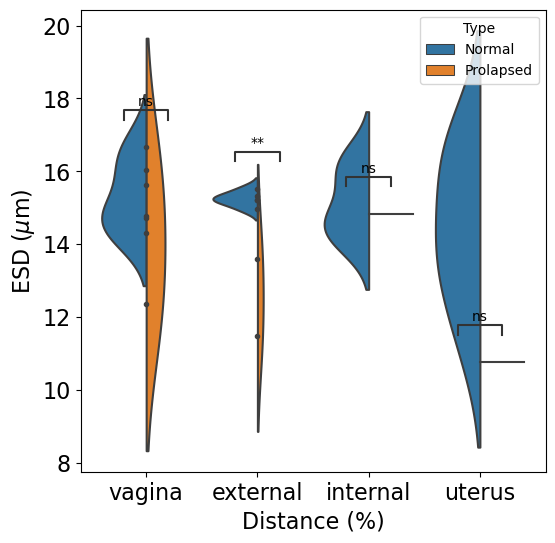

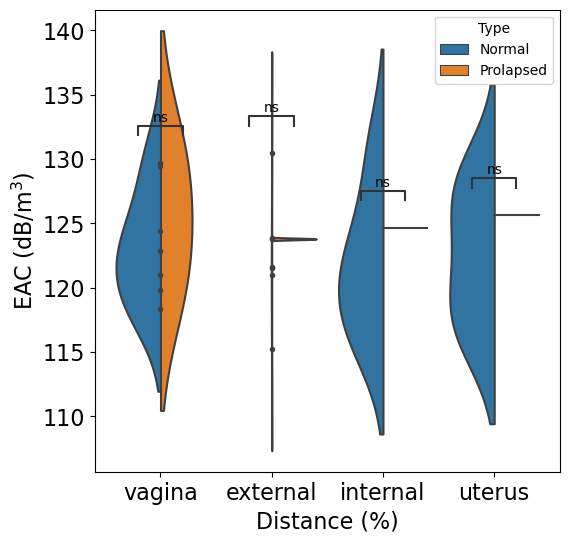

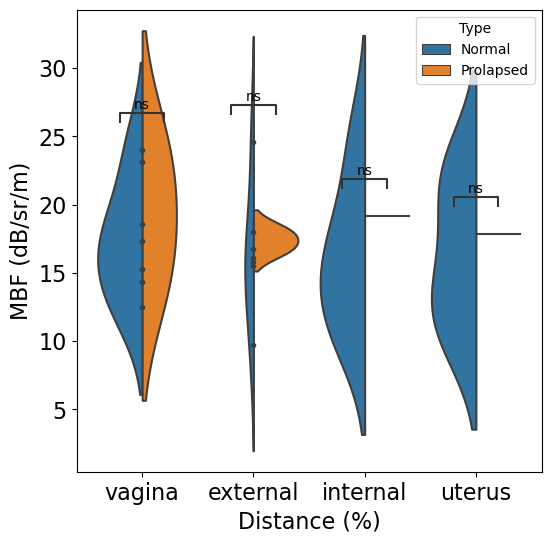

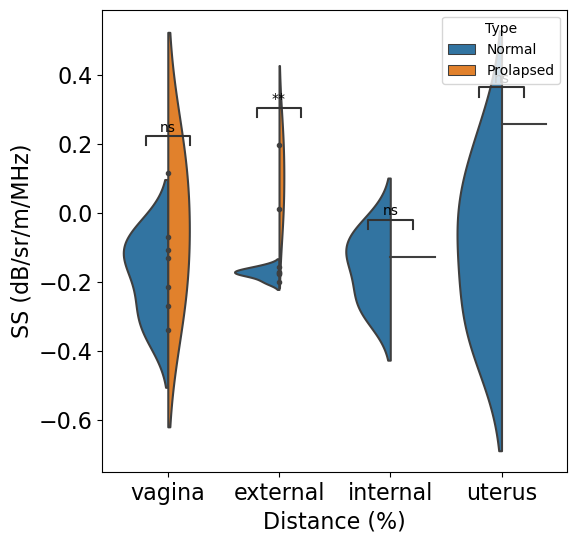

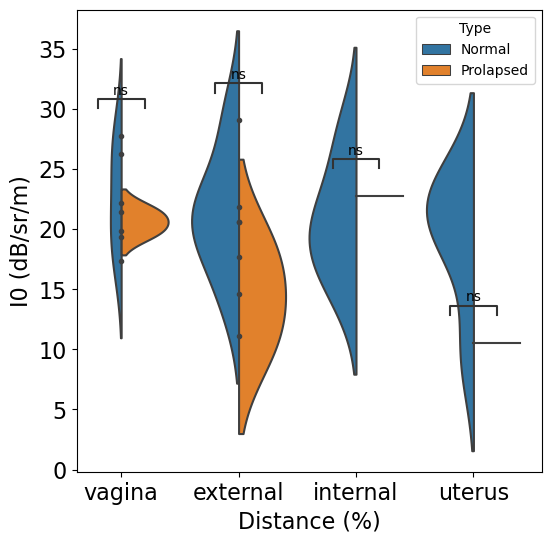

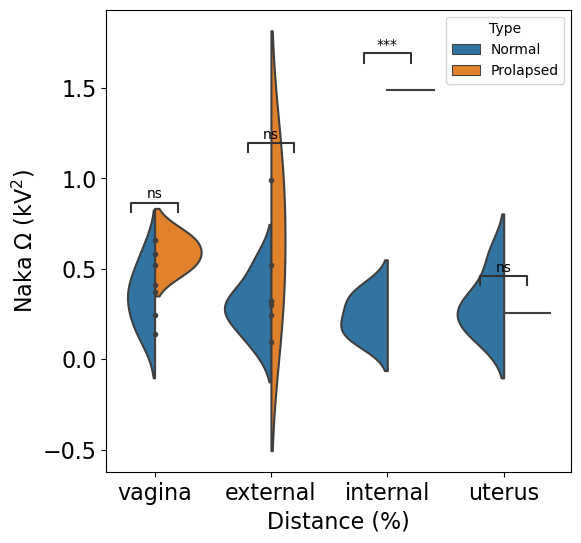

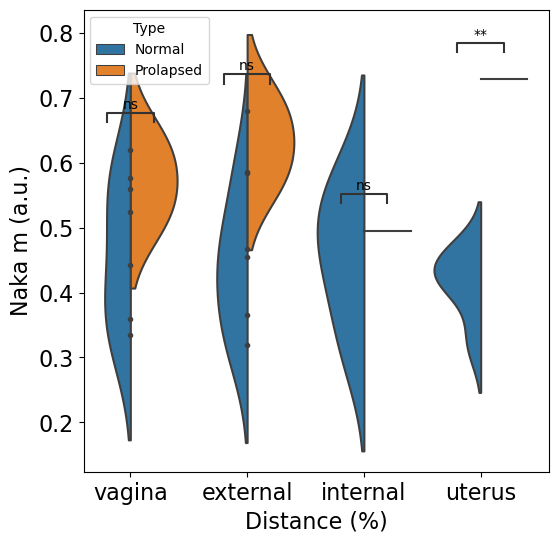

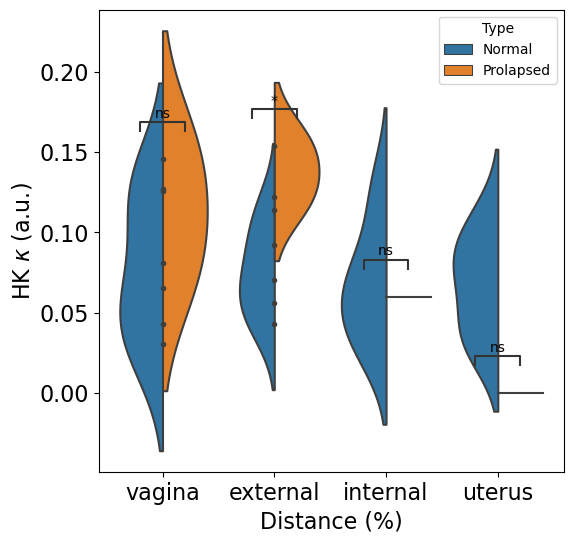

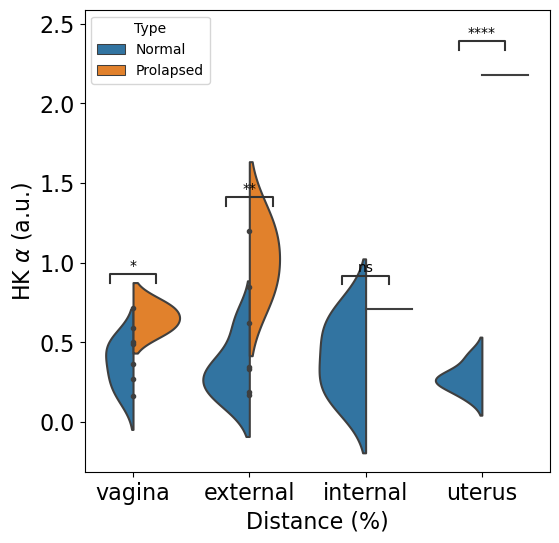

In [64]:
for q_idx, q_param in enumerate(qus_params):
    
    p_values = [None]*len(all_dist)
    for d_idx, dist in enumerate(all_dist):
        p_values[d_idx] =p_df_dist.loc[q_param][dist]

    print(p_values)
    
    this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

    
    hue_plot_params = {'data':in_data,'x':'Organ', 'order':all_dist, 'y': q_param,'hue':'Type','hue_order':all_types}
    violin_plot_params = {'data':in_data,'x':'Organ', 'order':all_dist, 'y': q_param,'hue':'Type','hue_order':all_types,'inner':'point','split':True}
    #hue_scatter = {'data':placenta_avg,'x':'Distance','y': q_param, 'hue':'Type','hue_order':['Normal','Preeclamptic'],'style':'ID'}

    #sns.scatterplot(ax=this_ax,**hue_scatter)
    #sns.boxplot(ax=this_ax,**hue_plot_params)
    sns.violinplot(ax=this_ax,**violin_plot_params)
    annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
    annotator.set_pvalues(p_values)
    annotator.annotate()


    this_ax.set_xlabel('Distance (%)',fontsize=16)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

In [ ]:
p_mat_d = np.zeros((len(qus_params),6))
diff_mat = np.zeros(p_mat_d.shape)

for d_idx, tp in enumerate(all_types):
    #print(dist)
    sub_df = in_data[in_data['Type'] == tp]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        var_0 = sub_df[sub_df['Distance'] == '0'][param]
        var_50 = sub_df[sub_df['Distance'] == '50'][param]
        var_100 = sub_df[sub_df['Distance'] == '100'][param]

        #print(var_c)
        #print(var_r)

        var_0_mean = np.mean(var_0)
        var_50_mean = np.mean(var_100)
        var_100_mean = np.mean(var_100)

        this_t, this_p = scipy.stats.ttest_ind(var_0.values.reshape(-1,1),var_50.values.reshape(-1,1))
        p_mat_d[q_idx,d_idx*3] = this_p
        diff_mat[q_idx,d_idx*3] = var_50_mean - var_0_mean


        this_t, this_p = scipy.stats.ttest_ind(var_50.values.reshape(-1,1),var_100.values.reshape(-1,1))
        p_mat_d[q_idx,d_idx*3 + 1] = this_p
        diff_mat[q_idx,d_idx*3 + 1] = var_100_mean - var_50_mean

        this_t, this_p = scipy.stats.ttest_ind(var_0.values.reshape(-1,1),var_100.values.reshape(-1,1))
        p_mat_d[q_idx,d_idx*3 + 2] = this_p
        diff_mat[q_idx,d_idx*3 + 2] = var_100_mean - var_0_mean


p_df_type = pd.DataFrame(p_mat_d,index=qus_params)
diff_df_type = pd.DataFrame(diff_mat,index=qus_params)

p_df_type

C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\926087669.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,d_idx*3] = this_p
C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\926087669.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,d_idx*3 + 1] = this_p
C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\926087669.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,d_idx*3 + 2] = this_p


,0,1,2,3,4,5
ESD,0.044883,6.475060e-09,6.071478e-04,0.000450,1.588032e-07,0.831999
EAC,0.000447,1.563664e-02,1.838085e-01,0.000043,6.118726e-07,0.375391
MBF,0.000687,1.244647e-01,7.003549e-03,0.000005,1.470075e-05,0.312369
SS,0.139827,5.264218e-10,3.079881e-04,0.000325,1.446058e-08,0.605557
I0,0.141805,4.778067e-09,2.685203e-08,0.030928,1.783195e-04,0.402492
Naka Omega,0.809623,7.334535e-01,9.160276e-01,0.512386,2.228024e-01,0.567161
Naka m,0.086316,6.908713e-06,9.775843e-02,0.984873,1.885629e-01,0.436854
HK k,0.020392,8.320793e-04,9.293188e-01,0.428499,8.457008e-01,0.663918
HK alpha,0.916762,2.848534e-04,1.492340e-02,0.151367,6.354371e-01,0.119245


In [ ]:
comp_pairs = [[("0","Normal"),("50","Normal")],[("50","Normal"),("100","Normal")],[("0","Normal"),("100","Normal")],
              [("0","Preeclamptic"),("50","Preeclamptic")],[("50","Preeclamptic"),("100","Preeclamptic")],[("0","Preeclamptic"),("100","Preeclamptic")]]

In [ ]:
#Calculate significance between each combination of distances for each parameter in each group.
#Next week
all_dist.astype(str)

array(['0', '50', '100'], dtype='<U11')

0    4.488299e-02
1    6.475060e-09
2    6.071478e-04
3    4.503828e-04
4    1.588032e-07
5    8.319991e-01
Name: ESD, dtype: float64
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0_Normal vs. 50_Normal: Custom statistical test, P_val:4.488e-02
50_Normal vs. 100_Normal: Custom statistical test, P_val:6.475e-09
0_Preeclamptic vs. 50_Preeclamptic: Custom statistical test, P_val:4.504e-04
50_Preeclamptic vs. 100_Preeclamptic: Custom statistical test, P_val:1.588e-07
0_Normal vs. 100_Normal: Custom statistical test, P_val:6.071e-04
0_Preeclamptic vs. 100_Preeclamptic: Custom statistical test, P_val:8.320e-01
0    4.472299e-04
1    1.563664e-02
2    1.838085e-01
3    4.324790e-05
4    6.118726e-07
5    3.753914e-01
Name: EAC, dtype: float64
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1

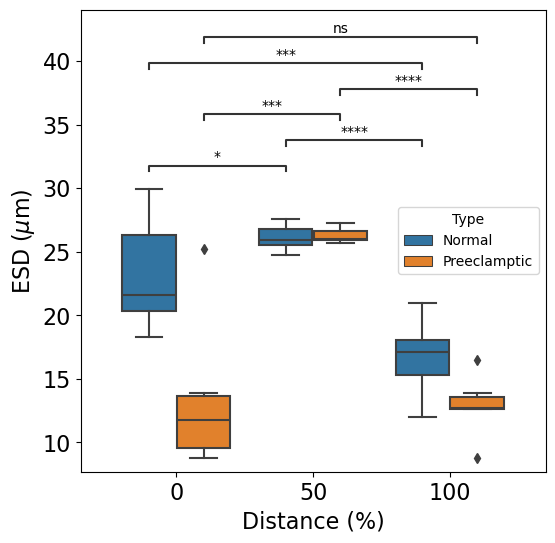

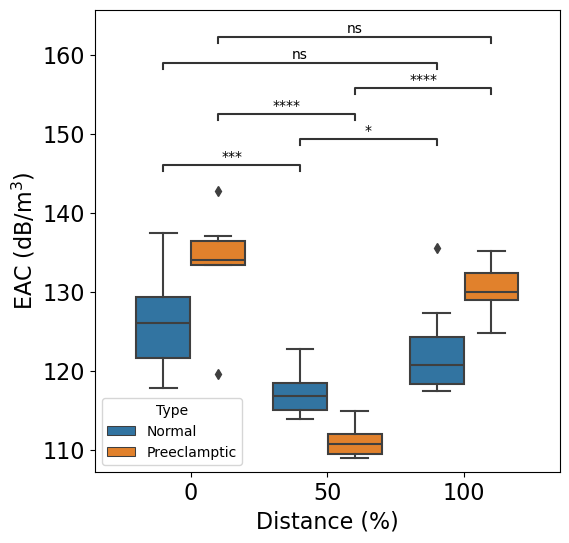

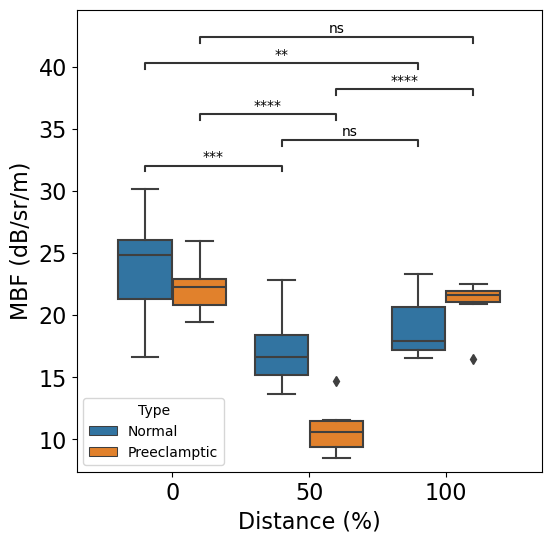

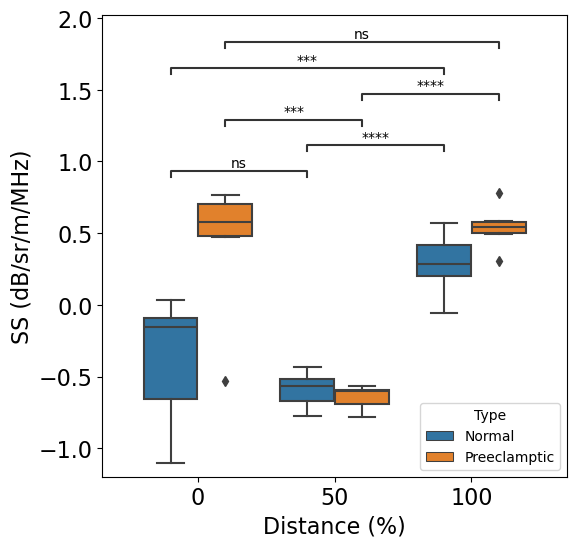

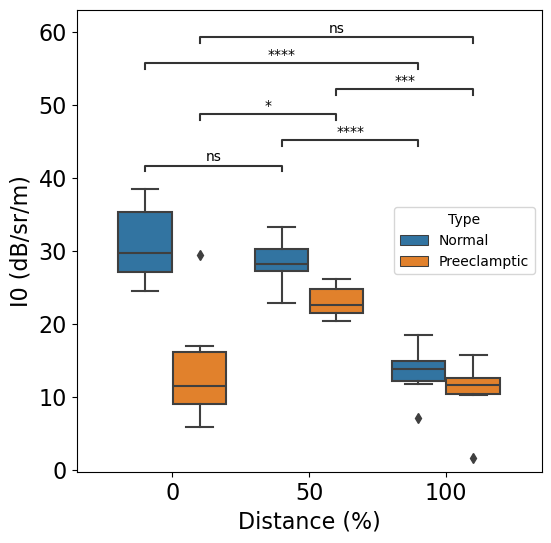

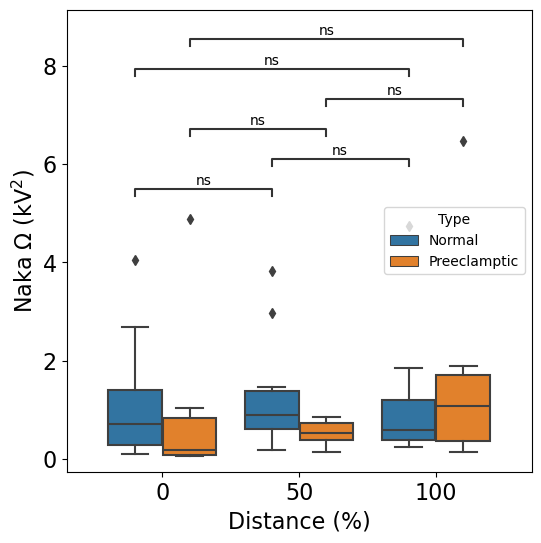

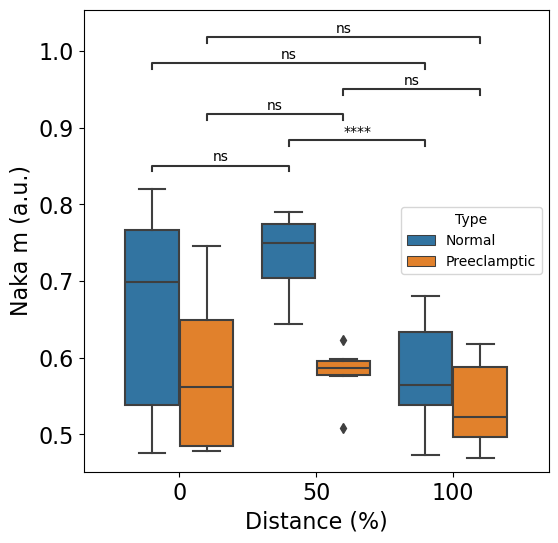

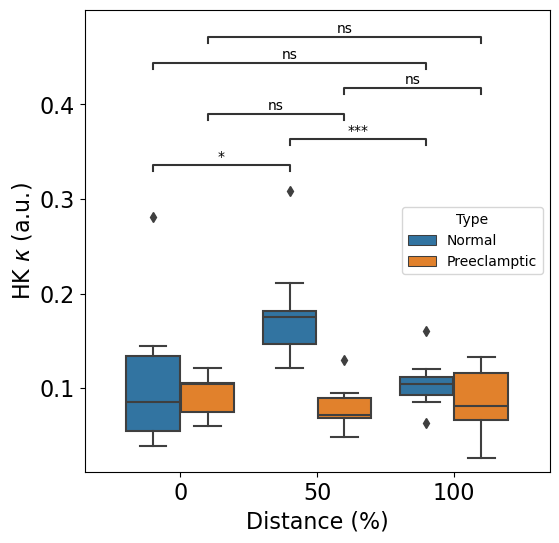

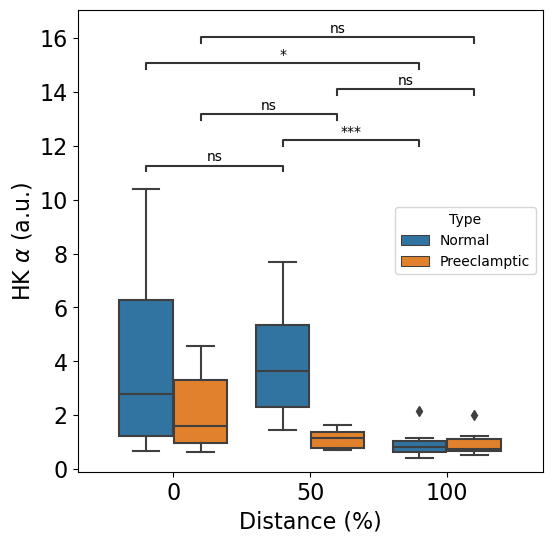

In [ ]:
#save_folder = r'2024-06-04'

for q_idx, q_param in enumerate(qus_params):
    #print(q_param)
    #this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

    #sns.boxplot(data=in_data,x='Zone',hue='Group',y=q_param,ax=this_ax,palette='tab10')
    # sns.stripplot(data=mean_data,x='Day',y=q_param,hue='ID',dodge=True,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

    

    # comp_pairs = [[('Labyrinth','Normal'),('Labyrinth','Preeclamptic')],
    #           [('Junctional','Normal'),('Junctional','Preeclamptic')],
    #           [('Labyrinth','Normal'),('Junctional','Normal')],
    #           [('Labyrinth','Preeclamptic'),('Junctional','Preeclamptic')]]
    # comp_pairs = [[('Normal','Labyrinth'),('Preeclamptic','Labyrinth')],
    #           [('Normal','Junctional'),('Preeclamptic','Junctional')],
    #           [('Normal','Labyrinth'),('Normal','Junctional')],
    #           [('Preeclamptic','Labyrinth'),('Preeclamptic','Junctional')]]

    # p_values = [p_df_zone.loc[q_param]['Labyrinth'],p_df_zone.loc[q_param]['Junctional'],p_df_cond.loc[q_param]['Normal'],p_df_cond.loc[q_param]['Preeclamptic']]

    p_values = [None]*len(all_types)
    p_values = p_df_type.loc[q_param]

    print(p_values)
    
    this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

    
    hue_plot_params = {'data':in_data,'x':'Distance', 'order': np.array(['0', '50', '100']), 'y': q_param,'hue':'Type','hue_order':['Normal','Preeclamptic']}
    #hue_scatter = {'data':placenta_avg,'x':'Distance','y': q_param, 'hue':'Type','hue_order':['Normal','Preeclamptic'],'style':'ID'}

    #sns.scatterplot(ax=this_ax,**hue_scatter)
    sns.boxplot(ax=this_ax,**hue_plot_params)
    annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
    annotator.set_pvalues(p_values)
    annotator.annotate()

    this_ax.set_xlabel('Distance (%)',fontsize=16)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=16)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    #save_str = f'{data_dir}\\_{q_param}_boxplot.png'
    #this_fig.savefig(save_str,bbox_inches='tight',dpi=150)


In [ ]:
#Curate data for correlation with histology data
#corr_data = in_data.groupby(['Type','Animal','Distance'],as_index = False).mean()
corr_data = in_data
corr_data.loc[:,'Region'] = 'None'
corr_data.loc[corr_data['Distance'] == '0','Region'] = 'Basal\nPlate'
corr_data.loc[corr_data['Distance'] == '50','Region'] = 'Labyrinth'
corr_data.loc[corr_data['Distance'] == '100','Region'] = 'Chorionic\nPlate'
corr_data.drop(corr_data.loc[corr_data['Region'] == 'None'].index,inplace=True)
 
#Anova analysis
model = ols('ESD ~ C(Region) + C(Type) + C(Region):C(Type)', data = corr_data).fit()
result = sm.stats.anova_lm(model, type=2)
print(result)

                     df      sum_sq     mean_sq          F        PR(>F)
C(Region)           2.0  955.399566  477.699783  45.132008  3.451114e-11
C(Type)             1.0  229.455396  229.455396  21.678433  3.226031e-05
C(Region):C(Type)   2.0  187.642960   93.821480   8.864044  6.144469e-04
Residual           42.0  444.549045   10.584501        NaN           NaN


C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\3239679340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data.loc[:,'Region'] = 'None'
C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\3239679340.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data.drop(corr_data.loc[corr_data['Region'] == 'None'].index,inplace=True)


In [ ]:
all_regions = ["Basal\nPlate","Labyrinth","Chorionic\nPlate"]
comp_pairs = [None]*len(all_regions)
print(comp_pairs)

for d_idx, dist in enumerate(all_regions):
    comp_pairs[d_idx] = [(dist,'Normal'),(dist,'Preeclamptic')]

print(comp_pairs)


[None, None, None]
[[('Basal\nPlate', 'Normal'), ('Basal\nPlate', 'Preeclamptic')], [('Labyrinth', 'Normal'), ('Labyrinth', 'Preeclamptic')], [('Chorionic\nPlate', 'Normal'), ('Chorionic\nPlate', 'Preeclamptic')]]


In [ ]:
p_mat = np.zeros((len(qus_params),len(all_regions)))
diff_mat = np.zeros(p_mat.shape)

for d_idx, dist in enumerate(all_regions):
    #print(dist)
    sub_df = corr_data[corr_data['Region'] == dist]
    #print(sub_df)

    for q_idx, param in enumerate(qus_params):
        var_c = sub_df[sub_df['Type'] == 'Normal'][param]
        var_r = sub_df[sub_df['Type'] == 'Preeclamptic'][param]

        #print(var_c)
        #print(var_r)

        var_c_mean = np.mean(var_c)
        var_r_mean = np.mean(var_r)

        this_t, this_p = scipy.stats.ttest_ind(var_c.values.reshape(-1,1),var_r.values.reshape(-1,1))

        #print(this_p)
        p_mat[q_idx,d_idx] = this_p
        diff_mat[q_idx,d_idx] = var_r_mean - var_c_mean


p_df_dist = pd.DataFrame(p_mat,index=qus_params,columns=all_regions)
diff_df_dist = pd.DataFrame(diff_mat,index=qus_params,columns=all_regions)

p_df_dist

C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\820744522.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat[q_idx,d_idx] = this_p


,Basal\nPlate,Labyrinth,Chorionic\nPlate
ESD,0.001726,0.712116,0.011767
EAC,0.044212,0.000459,0.008364
MBF,0.394275,0.000400,0.149042
SS,0.003574,0.346817,0.015695
I0,0.000171,0.003990,0.146288
Naka Omega,0.885161,0.132908,0.473953
Naka m,0.238710,0.000008,0.225045
HK k,0.663308,0.000921,0.235832
HK alpha,0.281977,0.005685,0.824005


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Labyrinth_Normal vs. Labyrinth_Preeclamptic: Custom statistical test, P_val:7.121e-01
Basal
Plate_Normal vs. Basal
Plate_Preeclamptic: Custom statistical test, P_val:1.726e-03


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Chorionic
Plate_Normal vs. Chorionic
Plate_Preeclamptic: Custom statistical test, P_val:1.177e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Labyrinth_Normal vs. Labyrinth_Preeclamptic: Custom statistical test, P_val:4.593e-04
Basal
Plate_Normal vs. Basal
Plate_Preeclamptic: Custom statistical test, P_val:4.421e-02
Chorionic
Plate_Normal vs. Chorionic
Plate_Preeclamptic: Custom statistical test, P_val:8.364e-03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Labyrinth_Normal vs. Labyrinth_Preeclamptic: Custom statistical test, P_val:3.998e-04
Basal
Plate_Normal vs. Basal
Plate_Preeclamptic: Custom statistical test, P_val:3.943e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Chorionic
Plate_Normal vs. Chorionic
Plate_Preeclamptic: Custom statistical test, P_val:1.490e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Labyrinth_Normal vs. Labyrinth_Preeclamptic: Custom statistical test, P_val:3.468e-01
Basal
Plate_Normal vs. Basal
Plate_Preeclamptic: Custom statistical test, P_val:3.574e-03
Chorionic
Plate_Normal vs. Chorionic
Plate_Preeclamptic: Custom statistical test, P_val:1.570e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Labyrinth_Normal vs. Labyrinth_Preeclamptic: Custom statistical test, P_val:3.990e-03
Basal
Plate_Normal vs. Basal
Plate_Preeclamptic: Custom statistical test, P_val:1.711e-04


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Chorionic
Plate_Normal vs. Chorionic
Plate_Preeclamptic: Custom statistical test, P_val:1.463e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Labyrinth_Normal vs. Labyrinth_Preeclamptic: Custom statistical test, P_val:1.329e-01
Basal
Plate_Normal vs. Basal
Plate_Preeclamptic: Custom statistical test, P_val:8.852e-01
Chorionic
Plate_Normal vs. Chorionic
Plate_Preeclamptic: Custom statistical test, P_val:4.740e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Labyrinth_Normal vs. Labyrinth_Preeclamptic: Custom statistical test, P_val:7.908e-06
Basal
Plate_Normal vs. Basal
Plate_Preeclamptic: Custom statistical test, P_val:2.387e-01
Chorionic
Plate_Normal vs. Chorionic
Plate_Preeclamptic: Custom stat

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Labyrinth_Normal vs. Labyrinth_Preeclamptic: Custom statistical test, P_val:9.208e-04
Basal
Plate_Normal vs. Basal
Plate_Preeclamptic: Custom statistical test, P_val:6.633e-01
Chorionic
Plate_Normal vs. Chorionic
Plate_Preeclamptic: Custom statistical test, P_val:2.358e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Labyrinth_Normal vs. Labyrinth_Preeclamptic: Custom statistical test, P_val:5.685e-03
Basal
Plate_Normal vs. Basal
Plate_Preeclamptic: Custom statistical test, P_val:2.820e-01
Chorionic
Plate_Normal vs. Chorionic
Plate_Preeclamptic: Custom statistical test, P_val:8.240e-01


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


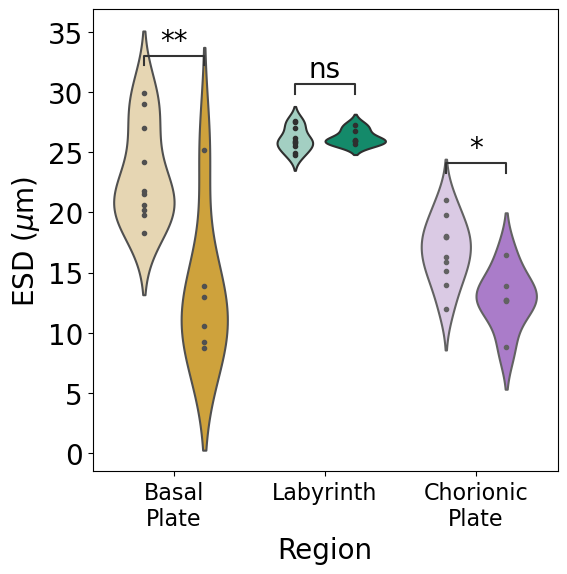

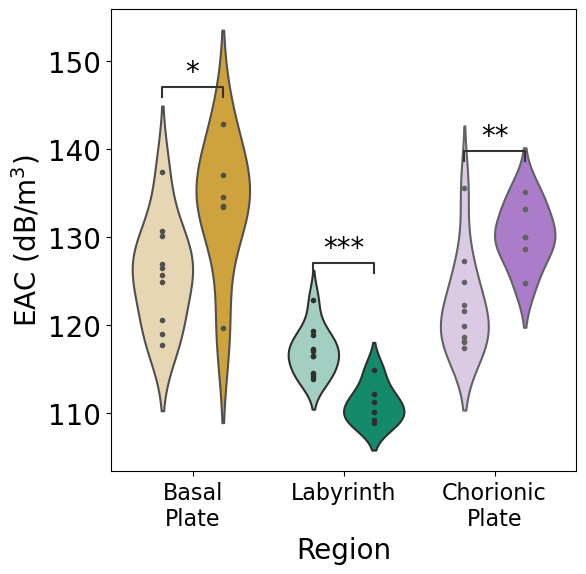

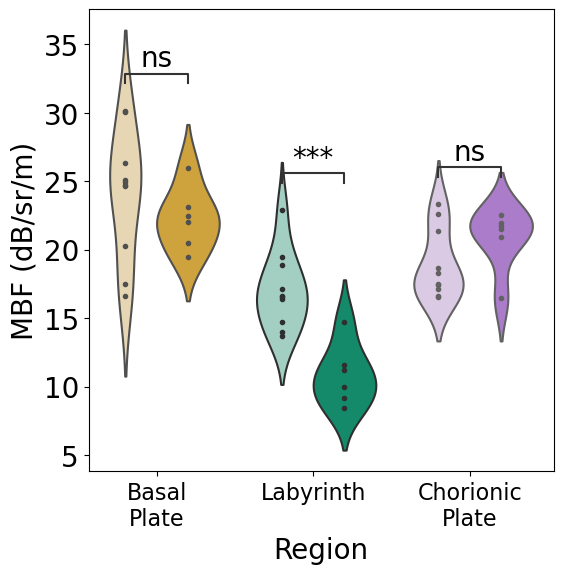

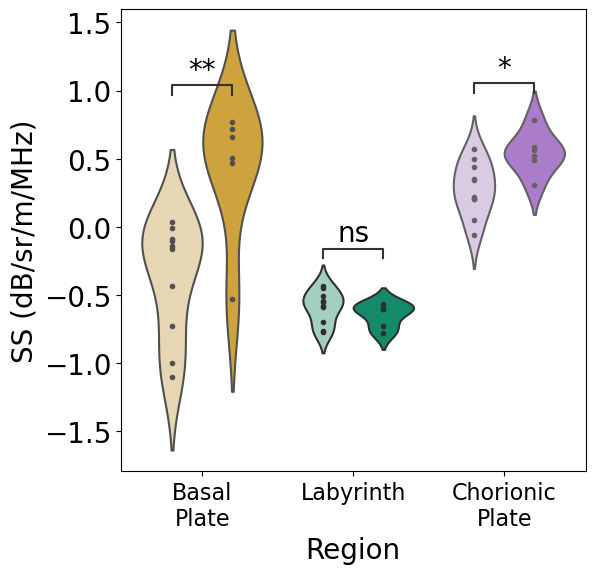

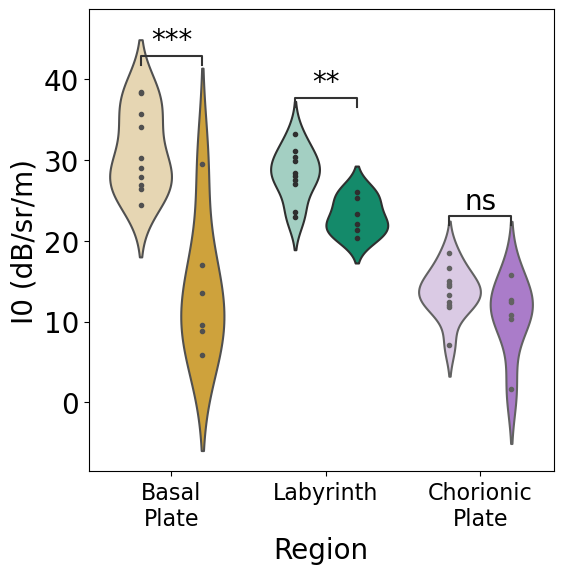

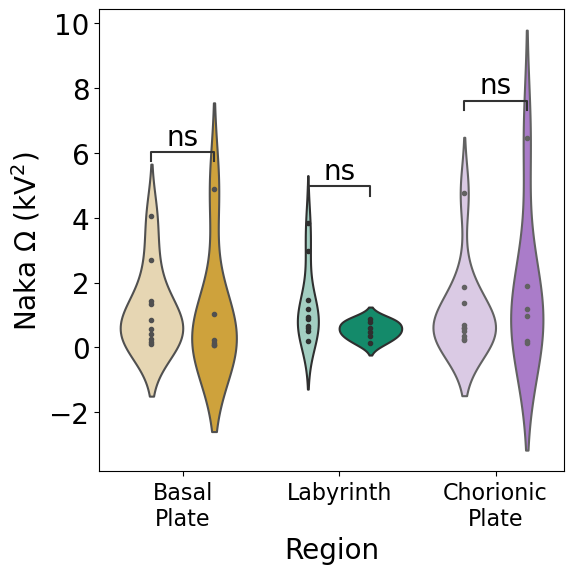

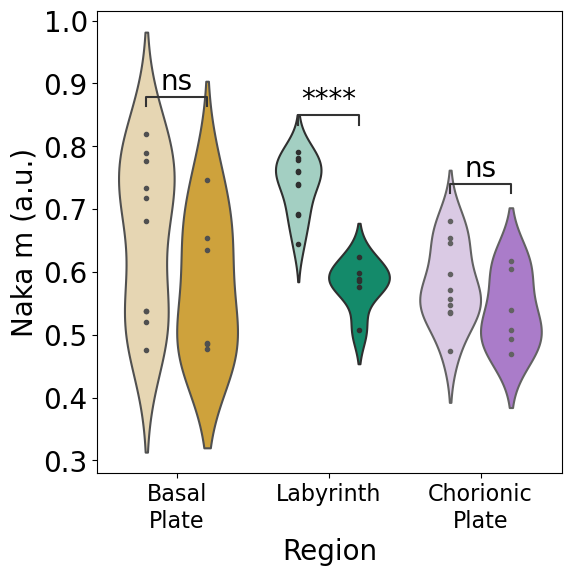

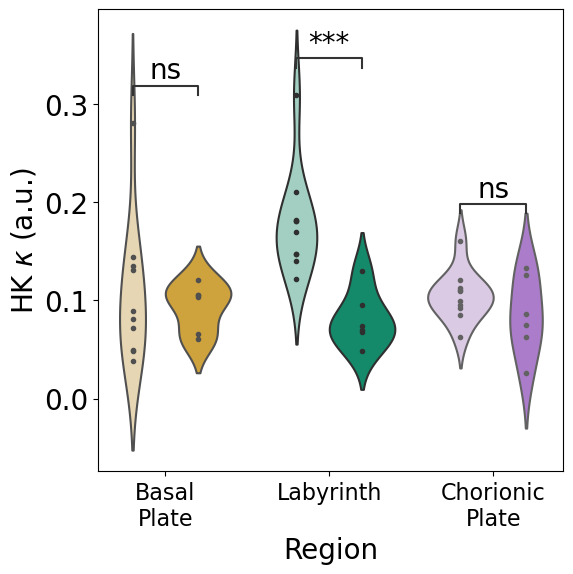

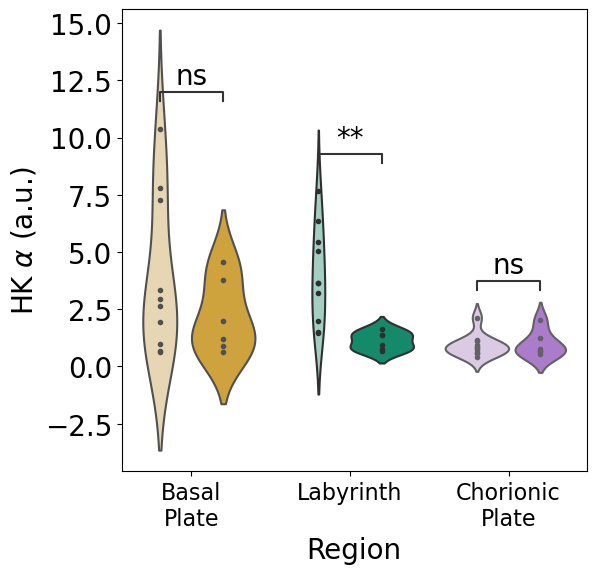

In [ ]:
for q_idx, q_param in enumerate(qus_params):
    
    this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

    p_values = [None]*len(all_regions)
    for d_idx, reg in enumerate(all_regions):
        p_values[d_idx] =p_df_dist.loc[q_param][reg]

        if d_idx == 0:
            cp = sns.color_palette("light:#E6AB24",4)
        elif d_idx == 1:
            cp = sns.color_palette("light:#009E73",4)
        elif d_idx == 2:
            cp = sns.color_palette("light:#AD6FD6",4)
        
        plot_data = corr_data[corr_data['Region']==reg]
        violin_plot_params = {'data':plot_data,'x':'Region', 'order':all_regions, 'y': q_param,'hue':'Type','hue_order':['Normal','Preeclamptic'],'inner':'point','palette':(cp[1],cp[3])}
        #hue_scatter = {'data':placenta_avg,'x':'Distance','y': q_param, 'hue':'Type','hue_order':['Normal','Preeclamptic'],'style':'ID'}

        #sns.scatterplot(ax=this_ax,**hue_scatter)
        #sns.boxplot(ax=this_ax,**hue_plot_params)
        sns.violinplot(ax=this_ax,**violin_plot_params)

    hue_plot_params = {'data':corr_data,'x':'Region', 'order':all_regions, 'y': q_param,'hue':'Type','hue_order':['Normal','Preeclamptic']}
    annotator = Annotator(this_ax,comp_pairs,**hue_plot_params)
    annotator.set_pvalues(p_values)
    annotator.configure(fontsize=20)
    annotator.annotate()


    this_ax.set_xlabel('Region',fontsize=20)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=20)

    #remove legend and replace with a custom one
    this_ax.legend([],[],frameon=False)
    #gp = sns.color_palette("Greys",4)
    #legend_elements =   [Patch(facecolor=gp[1],
    #                       label='Normal'),
    #                    Patch(facecolor=gp[3],
    #                        label='Preeclamptic')] 
    #this_ax.legend(title = 'Type',handles = legend_elements,loc='lower right')

[0.7121157615552749]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Normal vs. Preeclamptic: Custom statistical test, P_val:7.121e-01
[0.0004592866506431896]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Normal vs. Preeclamptic: Custom statistical test, P_val:4.593e-04
[0.0003998471684476236]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Normal vs. Preeclamptic: Custom statistical test, P_val:3.998e-04
[0.34681729172608033]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
   

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the tes

[0.13290802503910965]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Normal vs. Preeclamptic: Custom statistical test, P_val:1.329e-01
[7.908242658123693e-06]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Normal vs. Preeclamptic: Custom statistical test, P_val:7.908e-06
[0.0009207612069850263]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Normal vs. Preeclamptic: Custom statistical test, P_val:9.208e-04
[0.005684883794590177]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
 

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the tes

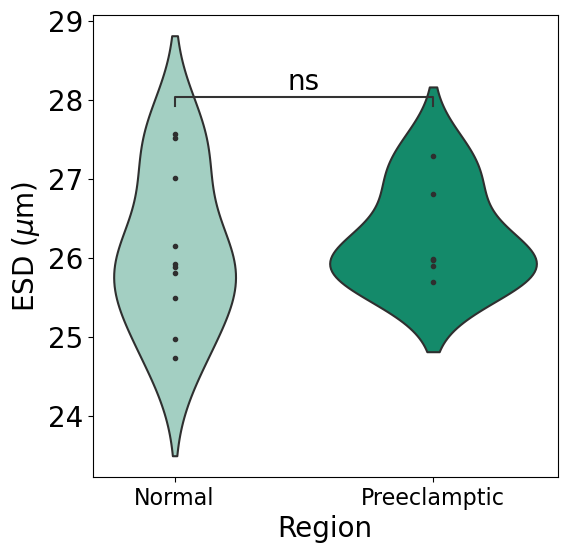

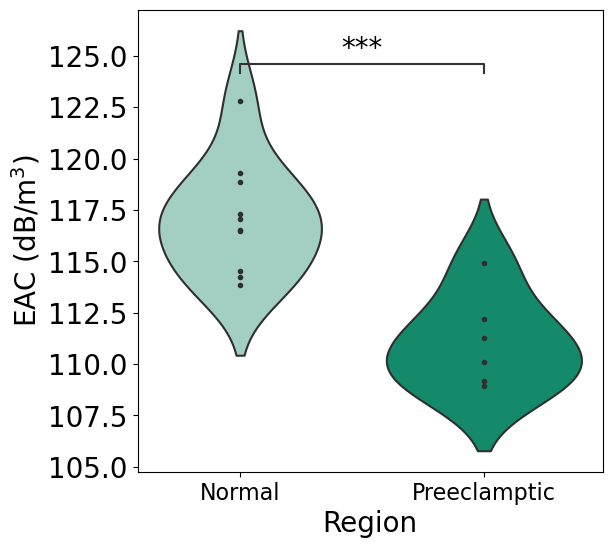

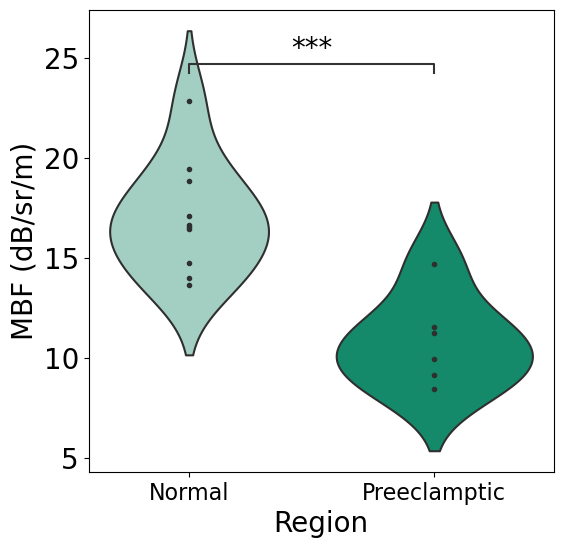

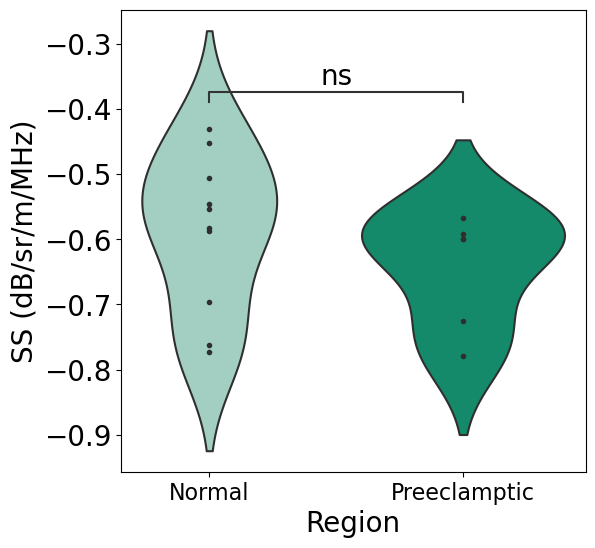

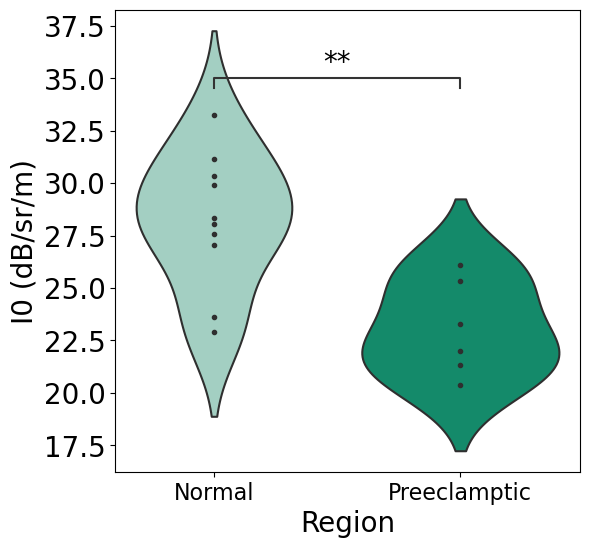

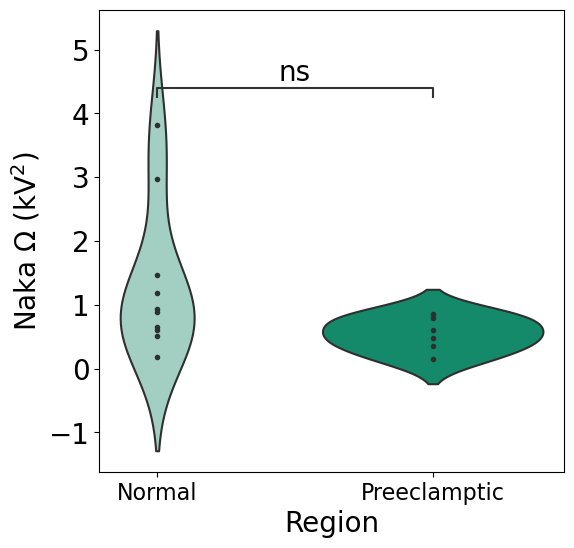

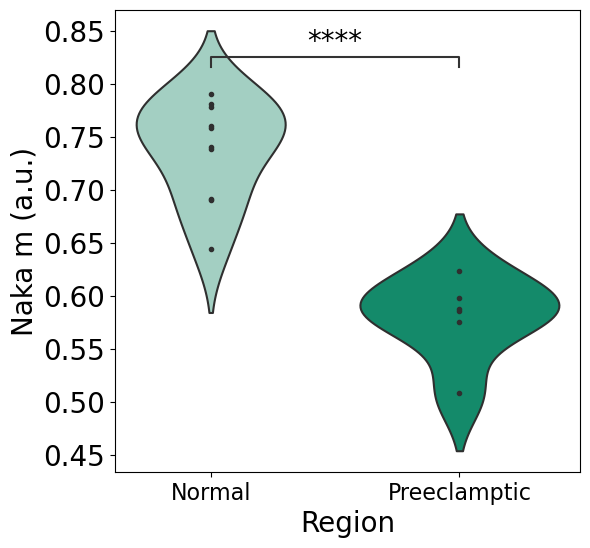

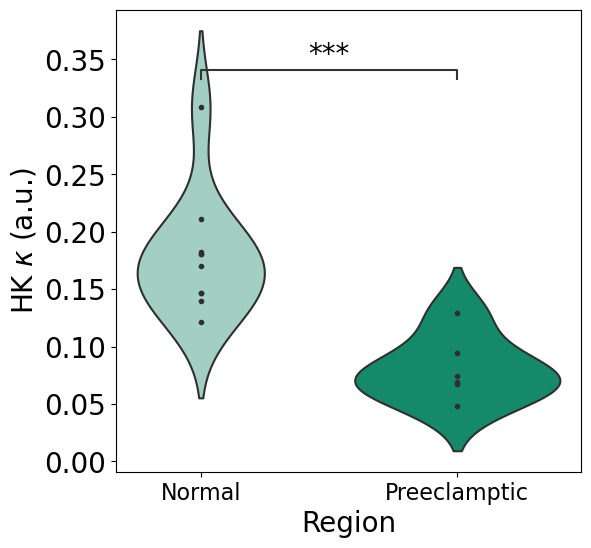

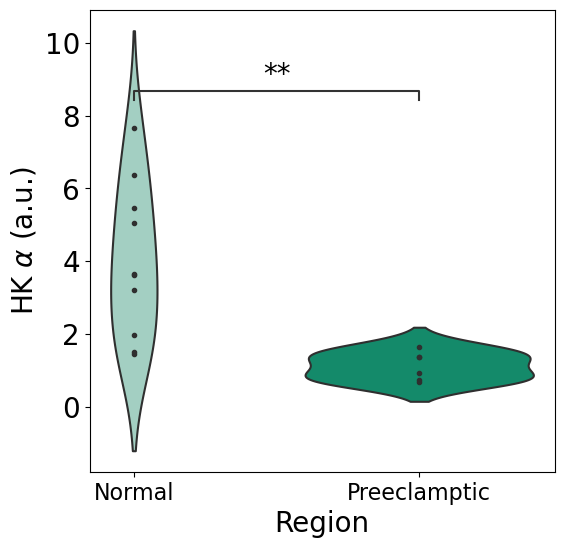

In [ ]:
reg = 'Labyrinth'
d_idx = 1
L_pairs = [('Normal','Preeclamptic')]

for q_idx, q_param in enumerate(qus_params):
    
    this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))

    p_values =[p_df_dist.loc[q_param][reg]]
    print(p_values)

    if d_idx == 0:
        cp = sns.color_palette("light:#E6AB24",4)
    elif d_idx == 1:
        cp = sns.color_palette("light:#009E73",4)
    elif d_idx == 2:
        cp = sns.color_palette("light:#AD6FD6",4)
    
    plot_data = corr_data[corr_data['Region']==reg]
    violin_plot_params = {'data':plot_data,'x':'Type', 'y': q_param,'inner':'point','palette':(cp[1],cp[3])}
    #hue_scatter = {'data':placenta_avg,'x':'Distance','y': q_param, 'hue':'Type','hue_order':['Normal','Preeclamptic'],'style':'ID'}

    #sns.scatterplot(ax=this_ax,**hue_scatter)
    #sns.boxplot(ax=this_ax,**hue_plot_params)
    sns.violinplot(ax=this_ax,**violin_plot_params)

    hue_plot_params = {'data':corr_data,'x':'Type','y': q_param}
    annotator = Annotator(this_ax,L_pairs,**hue_plot_params)
    annotator.set_pvalues(p_values)
    annotator.configure(fontsize=20)
    annotator.annotate()


    this_ax.set_xlabel('Region',fontsize=20)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=20)

    #remove legend and replace with a custom one
    this_ax.legend([],[],frameon=False)
    #gp = sns.color_palette("Greys",4)
    #legend_elements =   [Patch(facecolor=gp[1],
    #                       label='Normal'),
    #                    Patch(facecolor=gp[3],
    #                        label='Preeclamptic')] 
    #this_ax.legend(title = 'Type',handles = legend_elements,loc='lower right')

In [ ]:
p_mat_d = np.zeros((len(qus_params),6))
diff_mat = np.zeros(p_mat_d.shape)

for q_idx, param in enumerate(qus_params):
    for d_idx, tp in enumerate(all_types):
        #print(dist)
        sub_df = corr_data[corr_data['Type'] == tp]
        #print(sub_df)

        var_0 = sub_df[sub_df['Region'] == 'Basal\nPlate'][param]
        var_50 = sub_df[sub_df['Region'] == 'Labyrinth'][param]
        var_100 = sub_df[sub_df['Region'] == 'Chorionic\nPlate'][param]

        #print(var_r)

        var_0_mean = np.mean(var_0)
        var_50_mean = np.mean(var_100)
        var_100_mean = np.mean(var_100)

        this_t, this_p = scipy.stats.ttest_ind(var_0.values.reshape(-1,1),var_50.values.reshape(-1,1))
        p_mat_d[q_idx,d_idx*3] = this_p
        diff_mat[q_idx,d_idx*3] = var_50_mean - var_0_mean


        this_t, this_p = scipy.stats.ttest_ind(var_50.values.reshape(-1,1),var_100.values.reshape(-1,1))
        p_mat_d[q_idx,d_idx*3+1] = this_p
        diff_mat[q_idx,d_idx*3+1] = var_100_mean - var_50_mean

        this_t, this_p = scipy.stats.ttest_ind(var_0.values.reshape(-1,1),var_100.values.reshape(-1,1))
        p_mat_d[q_idx,d_idx*3+2] = this_p
        diff_mat[q_idx,d_idx*3+2] = var_100_mean - var_0_mean



p_df_type = pd.DataFrame(p_mat_d,index=qus_params)
diff_df_type = pd.DataFrame(diff_mat,index=qus_params)

p_df_type

C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\1195787234.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,d_idx*3] = this_p
C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\1195787234.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,d_idx*3+1] = this_p
C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\1195787234.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,d_idx*3+2] = this_p


,0,1,2,3,4,5
ESD,0.044883,6.475060e-09,6.071478e-04,0.000450,1.588032e-07,0.831999
EAC,0.000447,1.563664e-02,1.838085e-01,0.000043,6.118726e-07,0.375391
MBF,0.000687,1.244647e-01,7.003549e-03,0.000005,1.470075e-05,0.312369
SS,0.139827,5.264218e-10,3.079881e-04,0.000325,1.446058e-08,0.605557
I0,0.141805,4.778067e-09,2.685203e-08,0.030928,1.783195e-04,0.402492
Naka Omega,0.809623,7.334535e-01,9.160276e-01,0.512386,2.228024e-01,0.567161
Naka m,0.086316,6.908713e-06,9.775843e-02,0.984873,1.885629e-01,0.436854
HK k,0.020392,8.320793e-04,9.293188e-01,0.428499,8.457008e-01,0.663918
HK alpha,0.916762,2.848534e-04,1.492340e-02,0.151367,6.354371e-01,0.119245


In [ ]:
p_mat_d = np.zeros((len(qus_params),6))
diff_mat = np.zeros(p_mat_d.shape)

for q_idx, param in enumerate(qus_params):
    #print(dist)
    sub_df = corr_data
    #print(sub_df)

    var_0 = sub_df[sub_df['Region'] == 'Basal\nPlate'][param]
    var_50 = sub_df[sub_df['Region'] == 'Labyrinth'][param]
    var_100 = sub_df[sub_df['Region'] == 'Chorionic\nPlate'][param]

    #print(var_r)

    var_0_mean = np.mean(var_0)
    var_50_mean = np.mean(var_100)
    var_100_mean = np.mean(var_100)

    this_t, this_p = scipy.stats.ttest_ind(var_0.values.reshape(-1,1),var_50.values.reshape(-1,1))
    p_mat_d[q_idx,0] = this_p
    diff_mat[q_idx,0] = var_50_mean - var_0_mean


    this_t, this_p = scipy.stats.ttest_ind(var_50.values.reshape(-1,1),var_100.values.reshape(-1,1))
    p_mat_d[q_idx,1] = this_p
    diff_mat[q_idx,1] = var_100_mean - var_50_mean

    this_t, this_p = scipy.stats.ttest_ind(var_0.values.reshape(-1,1),var_100.values.reshape(-1,1))
    p_mat_d[q_idx,2] = this_p
    diff_mat[q_idx,2] = var_100_mean - var_0_mean



p_df_type = pd.DataFrame(p_mat_d,index=qus_params)
diff_df_type = pd.DataFrame(diff_mat,index=qus_params)

p_df_type

C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\1256097299.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,0] = this_p
C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\1256097299.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,1] = this_p
C:\Users\amarkel\AppData\Local\Temp\ipykernel_45884\1256097299.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_mat_d[q_idx,2] = this_p


,0,1,2,3,4,5
ESD,5.797347e-04,6.732523e-14,0.031763,0.0,0.0,0.0
EAC,2.258649e-07,3.168474e-06,0.166283,0.0,0.0,0.0
MBF,8.422070e-07,2.204330e-04,0.003561,0.0,0.0,0.0
SS,1.181501e-03,2.268257e-16,0.007373,0.0,0.0,0.0
I0,5.869251e-01,3.736471e-11,0.000150,0.0,0.0,0.0
Naka Omega,7.960049e-01,4.927796e-01,0.684935,0.0,0.0,0.0
Naka m,2.156206e-01,2.639245e-04,0.072636,0.0,0.0,0.0
HK k,7.714746e-02,2.055554e-02,0.784099,0.0,0.0,0.0
HK alpha,7.339626e-01,1.424292e-03,0.004474,0.0,0.0,0.0


In [ ]:
all_regions = ["Basal\nPlate","Labyrinth","Chorionic\nPlate"]
Normal_comp_pairs = [[("Basal\nPlate"),("Labyrinth")],[("Labyrinth"),("Chorionic\nPlate")],[("Basal\nPlate"),("Chorionic\nPlate")]]


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Basal
Plate vs. Labyrinth: Custom statistical test, P_val:5.797e-04
Labyrinth vs. Chorionic
Plate: Custom statistical test, P_val:6.733e-14
Basal
Plate vs. Chorionic
Plate: Custom statistical test, P_val:3.176e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Basal
Plate vs. Labyrinth: Custom statistical test, P_val:2.259e-07
Labyrinth vs. Chorionic
Plate: Custom statistical test, P_val:3.168e-06
Basal
Plate vs. Chorionic
Plate: Custom statistical test, P_val:1.663e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


Labyrinth vs. Chorionic
Plate: Custom statistical test, P_val:2.204e-04
Basal
Plate vs. Chorionic
Plate: Custom statistical test, P_val:3.561e-03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Basal
Plate vs. Labyrinth: Custom statistical test, P_val:1.182e-03
Labyrinth vs. Chorionic
Plate: Custom statistical test, P_val:2.268e-16
Basal
Plate vs. Chorionic
Plate: Custom statistical test, P_val:7.373e-03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Basal
Plate vs. Labyrinth: Custom statistical test, P_val:5.869e-01
Labyrinth vs. Chorionic
Plate: Custom statistical test, P_val:3.736e-11
Basal
Plate vs. Chorionic
Plate: Custom statistical test, P_val:1.504e-04


c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Basal
Plate vs. Labyrinth: Custom statistical test, P_val:7.960e-01
Labyrinth vs. Chorionic
Plate: Custom statistical test, P_val:4.928e-01
Basal
Plate vs. Chorionic
Plate: Custom statistical test, P_val:6.849e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Basal
Plate vs. Labyrinth: Custom statistical test, P_val:2.156e-01
Labyrinth vs. Chorionic
Plate: Custom statistical test, P_val:2.639e-04
Basal
Plate vs. Chorionic
Plate: Custom statistical test, P_val:7.264e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-

c:\Users\amarkel\AppData\Local\anaconda3\Lib\site-packages\statannotations\Annotator.py:813: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


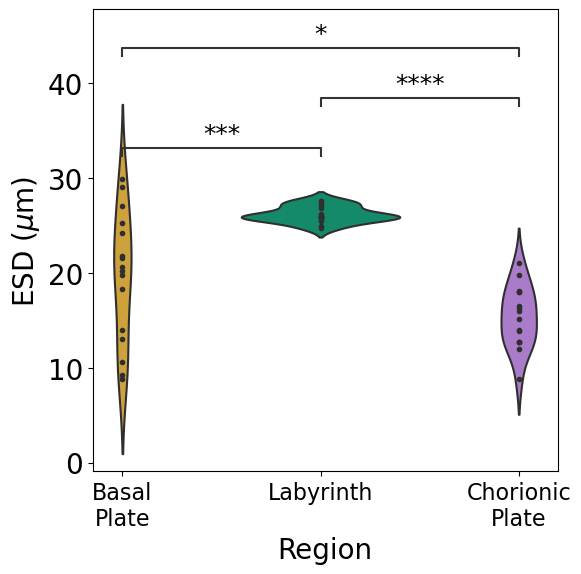

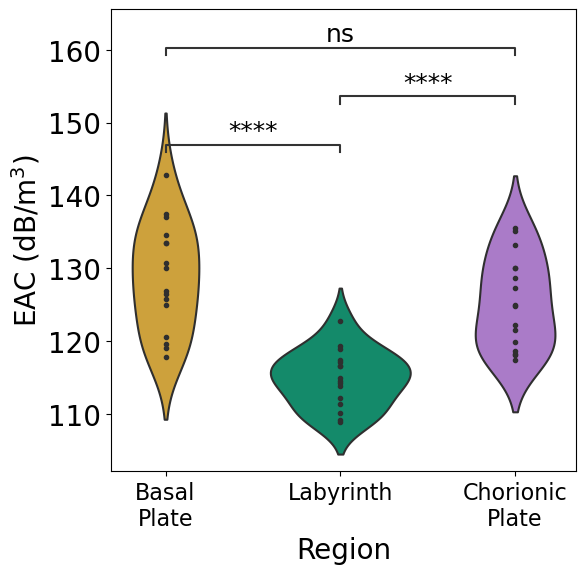

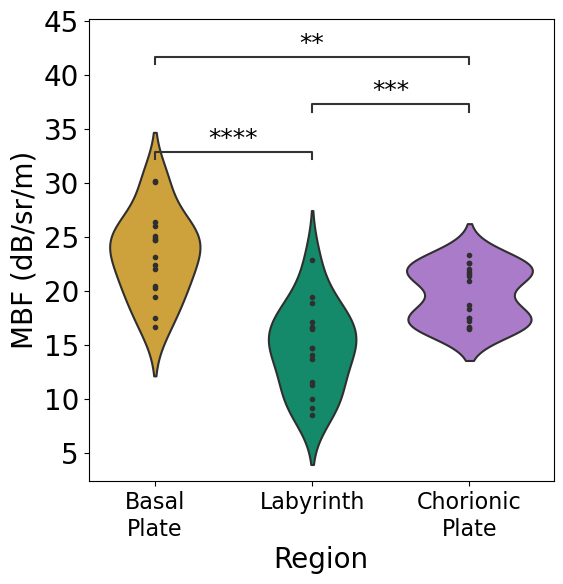

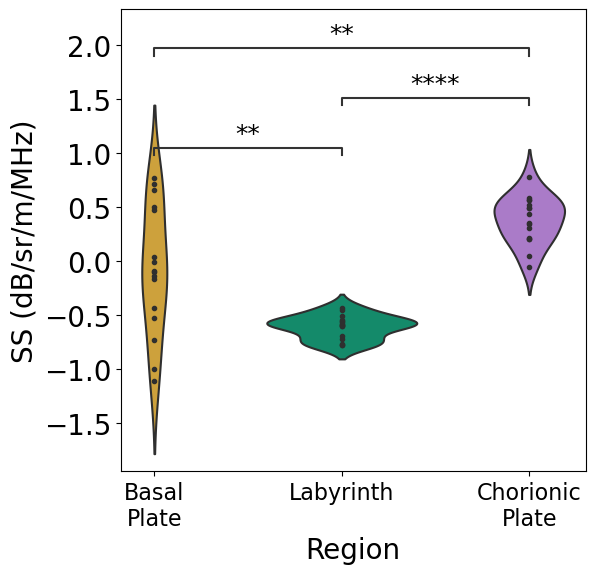

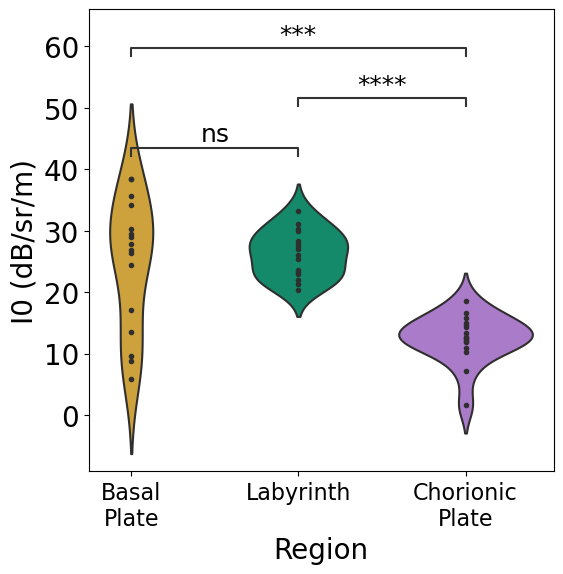

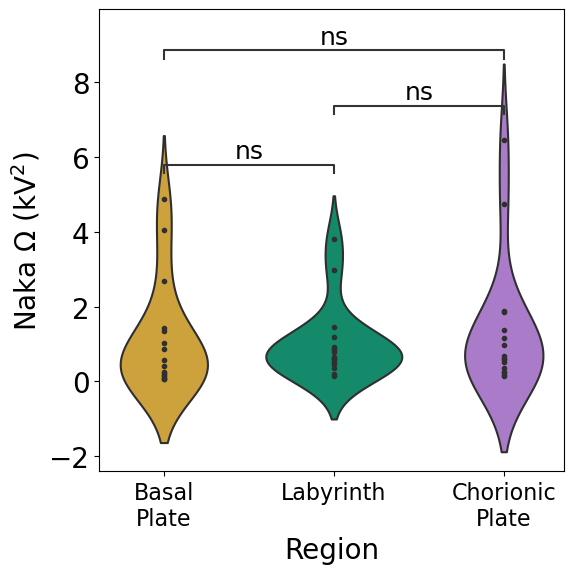

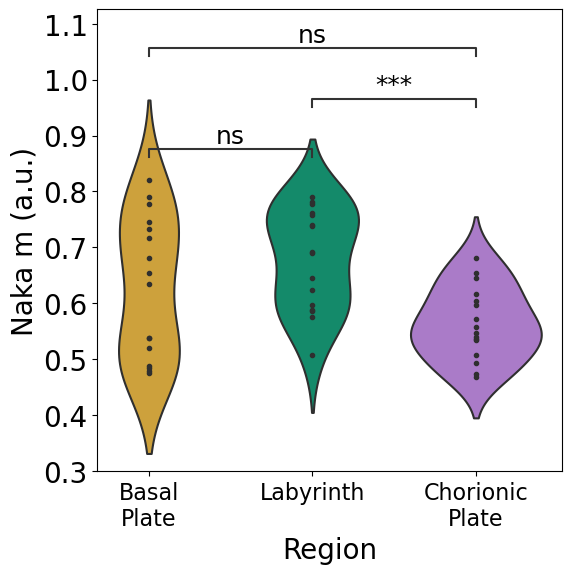

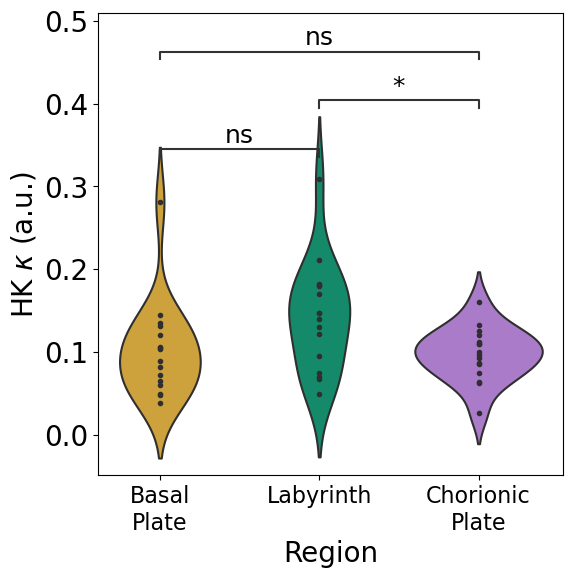

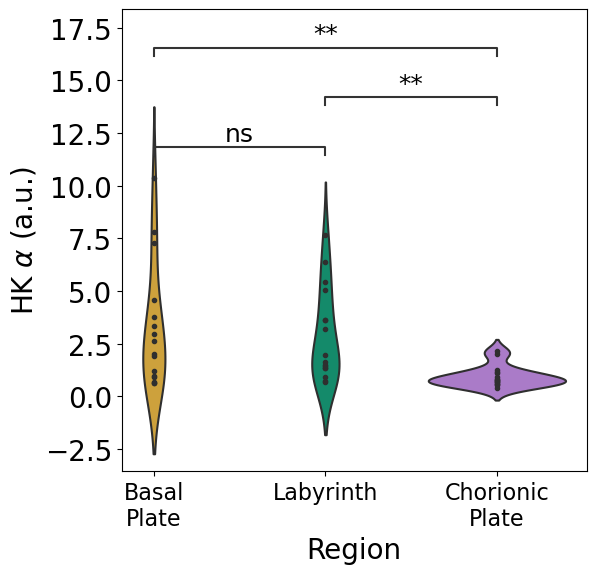

In [ ]:
for q_idx, q_param in enumerate(qus_params):

    p_values = [None]*len(all_types)
    p_values = p_df_type.loc[q_param]


    this_fig, this_ax = plt.subplots(1,1,figsize=(6,6))


    #hue_plot_params = {'data':in_data,'x':'Region','order':all_regions,'y': 'Measurement'}
    hue_plot_params = {'data':corr_data,'x':'Region','order':all_regions,'y': q_param,'inner':'point','palette':rp}
    #hue_scatter = {'data':in_data,'x':'Region', 'order':['Junctional Zone','Labyrinth Zone','Chorionic Plate'],'y': 'Measurement', 'hue':'Type','hue_order':['Normal','Preeclamptic'],'style':'ID'}

    #sns.scatterplot(ax=this_ax,**hue_scatter)
    #sns.boxplot(ax=this_ax,**hue_plot_params)
    sns.violinplot(ax=this_ax,**hue_plot_params)
    annotator = Annotator(this_ax,Normal_comp_pairs,**hue_plot_params)
    annotator.set_pvalues(p_values[0:3])
    annotator.configure(fontsize=18)
    annotator.annotate()

    this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=20)
    this_ax.set_ylabel(qus_params_key[q_idx],fontsize=20)
    # this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=20)

In [ ]:
#Clean, average, and save correlation data for export to compare with ESD
#for col in corr_data.columns:
#    if col != 'Region' and col != 'Animal' and col != 'Type' and col != 'ESD':
#            corr_data.drop(columns = [col],inplace=True)
#corr_data = corr_data.groupby(['Animal','Type','Region'],as_index=False).mean()
#corr_data
#save_dir = r'I:\Andrew Markel\Histology Data\2025-03-18_ESD.csv'
#corr_data.to_csv(save_dir)